In [24]:
import numpy as np
from lattice_class import *
from hamiltonian_constructor_class import *
import scipy.linalg
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150

Phase Triangle =  (6.123233995736766e-17+1j)
Phase Pentagon =  (6.123233995736766e-17-1j)
Flagged bonds triangle =  [(80, 130), (90, 131), (100, 132), (110, 133), (120, 134)]
Flagged bonds pentagon =  []


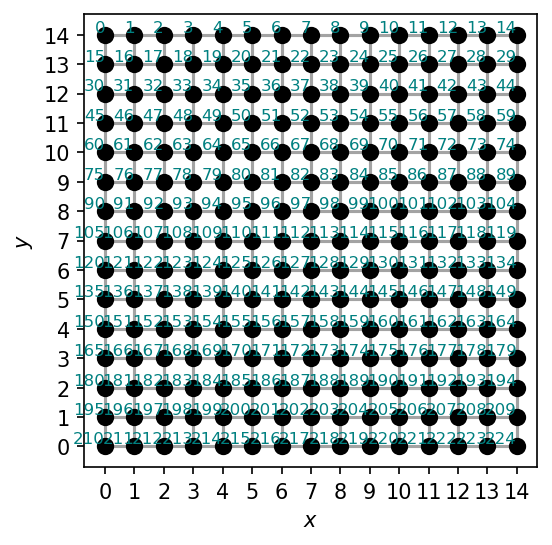

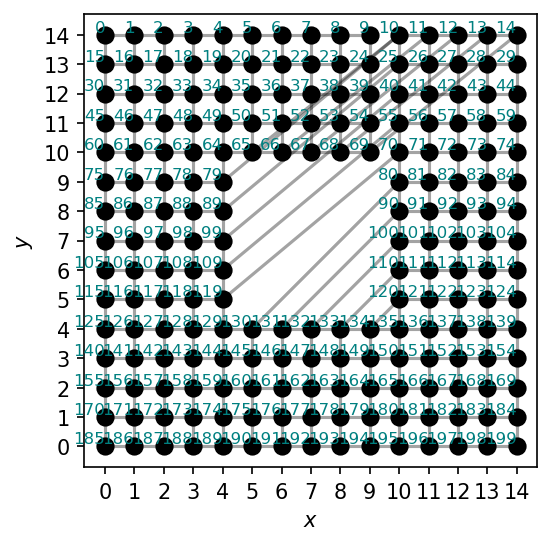

In [25]:
t = 1
mu = 2.0 * t
delta = complex(t, 0.0)
n = 1
phase_triangle = np.exp(n * np.pi * 1j / 2)
phase_pentagon = phase_triangle.conjugate()

N_hole = 5
N = 3 * N_hole
lattice = SquareLattice(N, BC="open")
middle_sites = [
    (N - N_hole) // 2 * N + (N - N_hole) // 2 + i * N + j
    for i in range(N_hole)
    for j in range(N_hole)
]

lattice.plot(True)

lattice.glue_bond(
    [2 * N_hole * N + N_hole + i for i in range(N_hole)],
    [N_hole * N + 2 * N_hole + i * N for i in range(N_hole)],
    (0, 2),
    codim=1,
)
lattice.glue_bond(
    [2 * N_hole * N + N_hole - 1 - (i + 1) * N for i in range(N_hole - 1)],
    [N_hole * N + 2 * N_hole - (i + 1) * N for i in range(N_hole - 1)],
    (1, 3),
    codim=1,
)
lattice.glue_bond([N_hole * N + N_hole - 1], [2 * N_hole], (1, 3), codim=1)
lattice.glue_bond([(N_hole - 1) * N + N_hole], [2 * N_hole], (2, 0), codim=1)
lattice.glue_bond(
    [(N_hole - 1) * N + N_hole + i + 1 for i in range(N_hole - 1)],
    [2 * N_hole + i + 1 for i in range(N_hole - 1)],
    (2, 0),
    codim=1,
)

lattice.remove_sites(middle_sites)
lattice.remove_bonds(
    [(2 * N_hole - 1 + i * N, 2 * N_hole + i * N) for i in range(N_hole)]
)

num_sites = lattice.get_num_sites()
lattice_sites = lattice.get_sites()

lattice.plot(True)
flagged_bonds_triangle = [
    (
        N_hole * N + N_hole + 2 * N_hole * i,
        N_hole * N + N_hole * (2 * N_hole) + N_hole + i,
    )
    for i in range(N_hole)
]
flagged_bonds_pentagon = []

print("Phase Triangle = ", phase_triangle)
print("Phase Pentagon = ", phase_pentagon)

print("Flagged bonds triangle = ", flagged_bonds_triangle)
print("Flagged bonds pentagon = ", flagged_bonds_pentagon)

Lowest found energy:  0.049883693935928314
Index of lowest absolute energy:  400


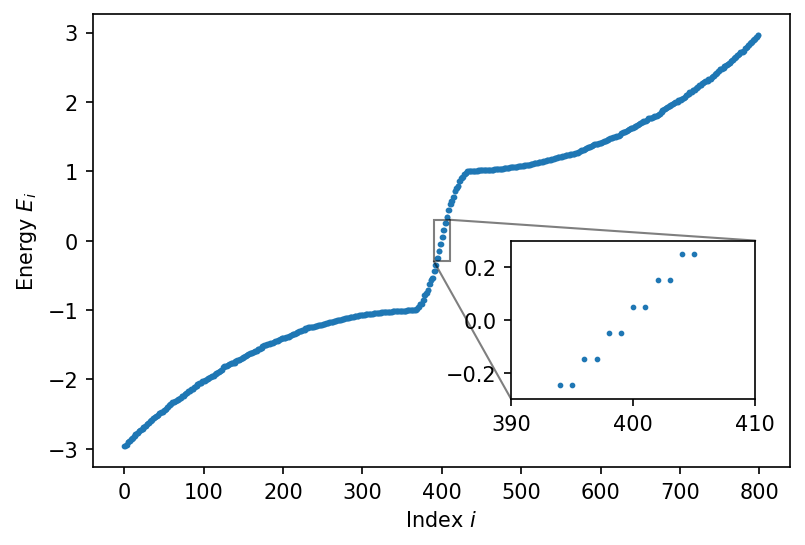

In [26]:
Ham_constructor = HamiltonianConstructor(mu, t, t, delta)
H_direct_lattice = Ham_constructor.construct_direct_lattice_hamiltonian(lattice)
block_indices = Ham_constructor.get_block_indices(lattice.get_num_sites())

for flagged_bond in flagged_bonds_triangle:
    Ham_constructor.add_phase(H_direct_lattice, flagged_bond, phase_triangle, num_sites)

for flagged_bond in flagged_bonds_pentagon:
    Ham_constructor.add_phase(H_direct_lattice, flagged_bond, phase_pentagon, num_sites)

energies, states = scipy.linalg.eigh(H_direct_lattice)

print("Lowest found energy: ", np.min(np.abs(energies)))
gs_idx = np.argmin(np.abs(energies))
print("Index of lowest absolute energy: ", gs_idx)

# Energy scatter plot with zoom window
fig, ax = plt.subplots()
plt.xlabel(r"Index $i$")
plt.ylabel(r"Energy $E_{i}$")
ax.scatter(range(len(energies)), energies, s=3)
axins = ax.inset_axes([0.6, 0.15, 0.35, 0.35])
axins.scatter(range(len(energies)), energies, s=3, zorder=-100)
x1, x2, y1, y2 = gs_idx - 10, gs_idx + 10, -0.3, 0.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.savefig(f"./plots/discl_dipole_spectrum_n_{n}.svg")
plt.show()

idx = 400 with energy 0.049883693935928314


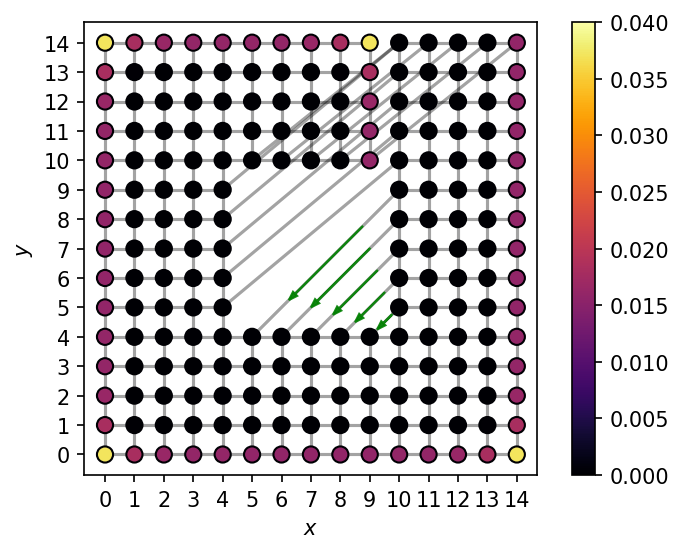

In [27]:
for gs_idx in range(gs_idx, gs_idx + 1):
    print(f"idx = {gs_idx} with energy {energies[gs_idx]}")
    gs_wave_function = states[:, gs_idx]
    gs_probabilities_nambu = np.square(np.abs(gs_wave_function))
    gs_probabilities = np.zeros(shape=(num_sites, 1))

    for site_idx in range(num_sites):
        gs_probabilities[site_idx] = np.sum(
            gs_probabilities_nambu[block_indices[site_idx]]
        )

    x_values = [k[0] for k in lattice_sites]
    y_values = [k[1] for k in lattice_sites]

    color_map = plt.get_cmap("inferno")
    sc = lattice.plot(
        False,
        c=(gs_probabilities),
        flagged_bonds=flagged_bonds_triangle,
        cmap=color_map,
    )
    plt.colorbar(sc)
    sc.set_clim(0.0, 0.04)
    plt.savefig(f"./plots/discl_dipole_prob_distr_n_{n}.svg")
    plt.show()

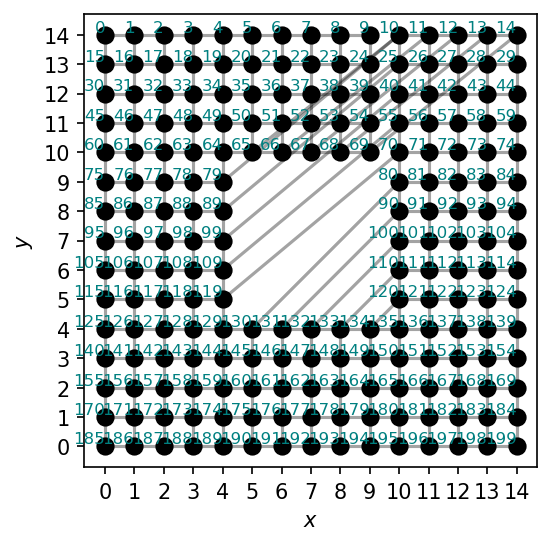

In [28]:
lattice.plot(True)

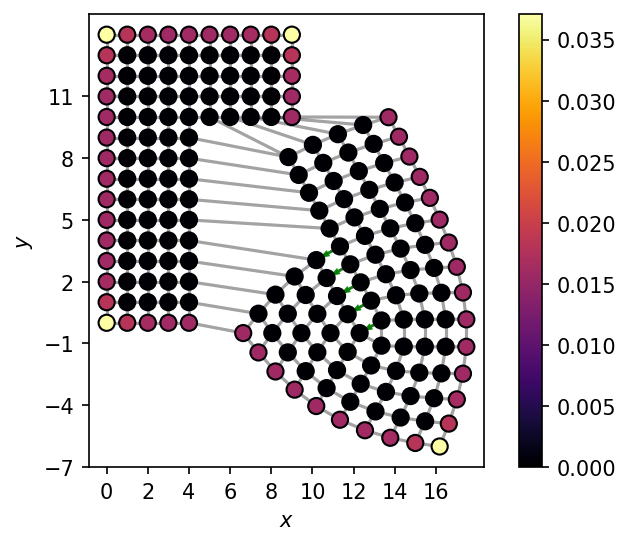

In [29]:
triangle_sites = []
for i in range(N_hole):
    for j in range(N_hole):
        triangle_sites.append(N_hole * N + N_hole + i * 2 * N_hole + j)
        triangle_sites.append(N_hole * N + N_hole * 2 * N_hole + N_hole + i * N + j)
        triangle_sites.append(N_hole * N + N_hole * 2 * N_hole + 2 * N_hole + i * N + j)
        triangle_sites.append(2 * N_hole + i * N + j)


def transform_triangle(pos, defect_pos, angle_sign=1):
    pos = np.array([pos[0], pos[1]])
    defect_pos = np.array([defect_pos[0], defect_pos[1]])
    pos_shift = pos - defect_pos
    x, y = -pos_shift
    r = scipy.linalg.norm(pos_shift)
    angle = np.arctan2(-y, x)
    if angle < 0.0:
        angle = angle_sign * 2 * np.pi + angle
    angle = angle * 4 / 3
    angle += -np.pi / 3
    return (
        r * np.array([-np.cos(angle), np.sin(angle)])
        + defect_pos
        + np.array([3.5, -5.0])
    )


for itr in triangle_sites:
    lattice.move_site(
        itr, transform_triangle(lattice._sites[itr], (9.5, 4.5), angle_sign=1)
    )

sc = lattice.plot(
    False, flagged_bonds=flagged_bonds_triangle, c=(gs_probabilities), cmap=color_map
)
plt.colorbar(sc)

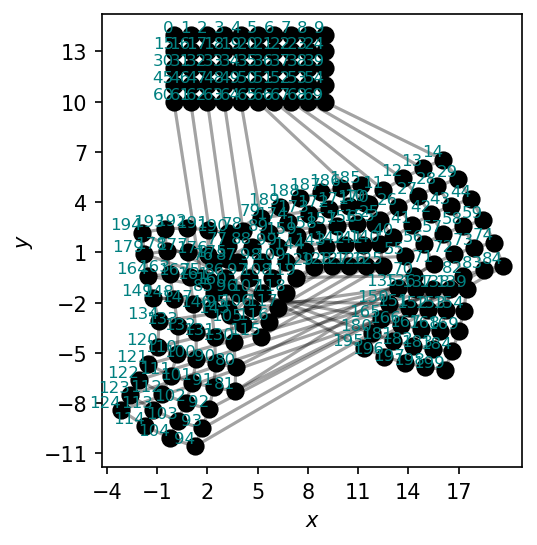

In [30]:
def transform_pentagon(pos, defect_pos, angle_sign=1):
    pos = np.array([pos[0], pos[1]])
    defect_pos = np.array([defect_pos[0], defect_pos[1]])
    pos_shift = pos - defect_pos
    x, y = pos_shift
    r = scipy.linalg.norm(pos_shift)
    angle = np.arctan2(y, x)
    if angle < 0.0:
        angle = angle_sign * 2 * np.pi + angle
    angle = angle * 4 / 3
    return r * np.array([np.cos(angle), np.sin(angle)]) + defect_pos


pentagon_sites = [i for i in range(lattice.get_num_sites())]
for triangle_site in [i * N + j for i in range(N_hole) for j in range(2 * N_hole)]:
    pentagon_sites.remove(triangle_site)

for site in [
    N_hole * N + N_hole * 2 * N_hole + 2 * N_hole + i * N + j
    for i in range(N_hole)
    for j in range(N_hole)
]:
    pentagon_sites.remove(site)

for itr in pentagon_sites:
    lattice.move_site(
        itr, transform_triangle(lattice._sites[itr], (4.5, 4.5), angle_sign=-1)
    )

lattice.plot(True)